# Exercise 3

## Occupancy grid mapping

The aim of this assignment is to implement a 2D occupancy grid mapping algorithm as described in the lecture. We provide data recorded by a robot using a 2D laser scanner in an indoor environment. 

The raw data is arranged in the following manner:

- `poses.data`: contains the **known** robot poses as it moves around the environment. Each line corresponds to the pose of the robot at a time instant

- `ranges.data`: contains 2d laser range measurements recorded by the robot. Each line corresponds to the range measurements taken from the corresponding robot poses.

---

### Log odds to probability

The occupancy calculations are usually performed using the log odds. We will need to convert between log odds and probabilities in this exercise. Implement the `logodds2prob` and `prob2logodds` functions. Verify that the conversion functions are correct for some test input. **[2.0]**

In [14]:
import numpy as np

def logodds2prob(log_odds):
    prob = 1 -  (1 / (1 + np.exp(log_odds)))
    return prob

def prob2logodds(prob):
    log_odds = np.log(prob / (1 - prob))
    return log_odds

In [15]:
prob = 0.3

print("Probability : ", prob)
log_odds = prob2logodds(prob)
print("Probability -> Log odds : ", log_odds)
cal_prob = logodds2prob(log_odds)
print("Log odds -> Probability : ", cal_prob)

Probability :  0.3
Probability -> Log odds :  -0.8472978603872036
Log odds -> Probability :  0.30000000000000004


---
### Inverse sensor model

The occupancy grid mapping relies on as inverse sensor model to update the occupancy of a cell in the grid. For this exercise, we consider a simple sensor model, where the occupancy of cell $m_i$ is $P_{occ}$ if the measurement $z_t$ falls in that cell, otherwise the occupancy is $P_{free}$. 

However, if the cell $m_i$ is not in the perception field, the occupancy will be $P_{prior}$.

Use the  following probabilities in the implementation:
$$P_{occ} = 0.9, P_{free} = 0.35, P_{prior} = 0.5 $$

Implement the inverse sensor model function and verify that it is correct for some test input. **[2.0]**

In [16]:
import ex3
import numpy as np
import matplotlib.pyplot as plt

def inv_sensor_model(cell, endpoint, prob_occ, prob_free):
    check_cell = ex3.bresenham(cell[0], cell[1], endpoint[0], endpoint[1])
    if check_cell.shape[0] == 0:
        free_cell = np.array([])
        occ_cell = np.array([])
    elif check_cell.shape[0] == 1:
        free_cell = np.array([])
        occ_cell = np.array([check_cell[0,0], check_cell[0, 1]])
    elif check_cell.shape[0] > 1:
        free_cell = np.array(check_cell[0:-1,:])
        occ_cell = np.array(check_cell[-1,:])
    return free_cell, occ_cell

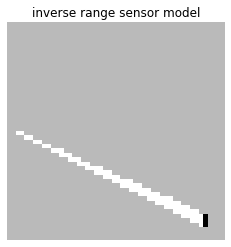

In [17]:
prior = 0.50
prob_occ = 0.90
prob_free = 0.35

sample_map = np.ones((50, 50)) * prior
cell = np.array([25, 2])
end_point = np.array([45, 45])

free_cell, occ_cell = inv_sensor_model(cell, end_point, prob_occ, prob_free)

for cell_ in free_cell:
    sample_map[cell_[0], cell_[1]] = prob_free
sample_map[occ_cell[0], occ_cell[1]] = prob_occ

cell = np.array([25, 2])
end_point = np.array([44, 45])

free_cell, occ_cell = inv_sensor_model(cell, end_point, prob_occ, prob_free)

for cell_ in free_cell:
    sample_map[cell_[0], cell_[1]] = prob_free
sample_map[occ_cell[0], occ_cell[1]] = prob_occ

cell = np.array([25, 2])
end_point = np.array([46, 45])

free_cell, occ_cell = inv_sensor_model(cell, end_point, prob_occ, prob_free)

for cell_ in free_cell:
    sample_map[cell_[0], cell_[1]] = prob_free
sample_map[occ_cell[0], occ_cell[1]] = prob_occ
    
plt.imshow(1-sample_map, cmap='gray')
plt.axis("off")
plt.title("inverse range sensor model")
plt.show()

---
### Occupancy grid mapping algorithm:

Implement the occupancy grid mapping algorithm as described in lecture slides. 

We provide some functions to make the implemntation easier.

- `ranges2cells` converts the raw measurements acquired by the robot (*ranges_raw*) into the correspoding cells of the gridmap.
- `poses2cells` converts the raw poses of the robot (*poses_raw*) into the correspoding cells of the gridmap.
- `bresenham` returns all the cells along a straigh line between two points in the gridmap.

Other parameters you may need in the implemntation are provided below.

Implement the `grid_mapping_with_known_poses` functionn and compute the resulting occupancy grid map using all the measurements provided in the data.

Plot the final occupancy gridmap using the `plot_gridmap` function. **[6.0]**


In [144]:
import numpy as np
import matplotlib.pyplot as plt
import bresenham as bh

def plot_gridmap(gridmap):
    plt.figure(figsize=(10,10))
    plt.imshow(gridmap, cmap='Greys',vmin=0, vmax=1)
    
def init_gridmap(size, res):
    gridmap = np.zeros([int(np.ceil(size/res)), int(np.ceil(size/res))])
    return gridmap

def world2map(pose, gridmap, map_res):
    origin = np.array(gridmap.shape)/2
    if pose.size == 3:
        new_pose = np.zeros(2)
        
        new_pose[0] = np.round(pose[0]/map_res) + origin[0]
        new_pose[1] = np.round(pose[1]/map_res) + origin[1]
        
    else:
        new_pose = np.zeros((2, pose.shape[1]))
        
        new_pose[0, :] = np.round(pose[0, :]/map_res) + origin[0]
        new_pose[1, :] = np.round(pose[1, :]/map_res) + origin[1]
    return new_pose.astype(int)

def v2t(pose):
    c = np.cos(pose[2])
    s = np.sin(pose[2])
    tr = np.array([[c, -s, pose[0]], [s, c, pose[1]], [0, 0, 1]])
    return tr    

def ranges2points(ranges):
    # laser properties
    start_angle = -1.5708
    angular_res = 0.0087270
    max_range = 30
    # rays within range
    num_beams = ranges.shape[0]
    idx = (ranges < max_range) & (ranges > 0)
    # 2D points
    angles = np.linspace(start_angle, start_angle + (num_beams*angular_res), num_beams)[idx]
    points = np.array([np.multiply(ranges[idx], np.cos(angles)), np.multiply(ranges[idx], np.sin(angles))])
    # homogeneous points
    points_hom = np.append(points, np.ones((1, points.shape[1])), axis=0)
    return points_hom

def ranges2cells(r_ranges, w_pose, gridmap, map_res):
    # ranges to points
    r_points = ranges2points(r_ranges)
    w_P = v2t(w_pose)
    w_points = np.matmul(w_P, r_points)
    # covert to map frame
    m_points = world2map(w_points, gridmap, map_res)
    m_points = m_points[0:2,:]
    return m_points

def poses2cells(w_pose, gridmap, map_res):
    # covert to map frame
    m_pose = world2map(w_pose, gridmap, map_res)
    return m_pose  

def bresenham(x0, y0, x1, y1):
    l = np.array(list(bh.bresenham(x0, y0, x1, y1)))
    return l
    
def logodds2prob(log_odds):
    prob = 1 -  (1 / (1 + np.exp(log_odds)))
    return prob

def prob2logodds(prob):
    if prob == 1:
        prob = 0.99
    log_odds = np.log(prob / (1 - prob))
    return log_odds
    
def inv_sensor_model(cell, endpoint, prob_occ, prob_free):
    check_cell = bresenham(cell[0], cell[1], endpoint[0], endpoint[1])
    if check_cell.shape[0] == 0:
        free_cell = np.array([])
        occ_cell = np.array([])
    elif check_cell.shape[0] == 1:
        free_cell = np.array([])
        occ_cell = np.array([check_cell[0,0], check_cell[0, 1]])
    elif check_cell.shape[0] > 1:
        free_cell = np.array(check_cell[0:-1,:])
        occ_cell = np.array(check_cell[-1,:])
    return free_cell, occ_cell

def grid_mapping_with_known_poses(ranges_raw, poses_raw, occ_gridmap, map_res, prob_occ, prob_free, prior):
    m_current_point = poses2cells(poses_raw, occ_gridmap, map_res)
    m_points = ranges2cells(ranges_raw, poses_raw, occ_gridmap, map_res)

    for i in range(m_points.shape[1]):
        x_ = m_points[0, i]
        y_ = m_points[1, i]
        
        free_cell, occ_cell = inv_sensor_model(m_current_point, [x_, y_], prob_occ, prob_free)
        
        # free_cell
        for j in range(free_cell.shape[0]):
            log_odds_ = prob2logodds(occ_gridmap[free_cell[j,0], free_cell[j,1]]) + prob2logodds(prob_free) - prob2logodds(prior)
            occ_gridmap[free_cell[j,0], free_cell[j,1]] = logodds2prob(log_odds_)
        # occ_cell
        log_odds_ = prob2logodds(occ_gridmap[occ_cell[0], occ_cell[1]]) + prob2logodds(prob_occ) - prob2logodds(prior)
        occ_gridmap[occ_cell[0], occ_cell[1]] = logodds2prob(log_odds_)
    
    return occ_gridmap

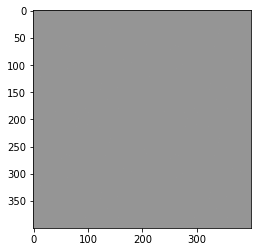

In [146]:
import ex3
import numpy as np
%matplotlib inline

map_size = 100
map_res = 0.25

prior = 0.50
prob_occ = 0.90
prob_free = 0.35

# load data
ranges_raw = np.loadtxt("ranges.data", delimiter=',', dtype='float')
poses_raw = np.loadtxt("poses.data", delimiter=',', dtype='float')

# initialize gridmap
occ_gridmap = ex3.init_gridmap(map_size, map_res)+prior
ex3.plot_gridmap(occ_gridmap)

In [114]:
# Raw data size
print('Poses Raw : ', poses_raw.shape)
print('Ranges Raw : ', ranges_raw.shape)

Poses Raw :  (686, 3)
Ranges Raw :  (686, 361)


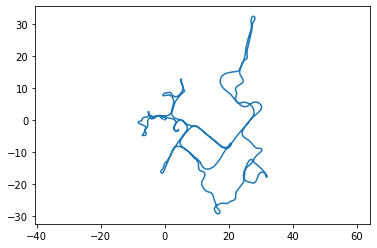

In [115]:
# Plot poses
import matplotlib.pyplot as plt

x = poses_raw.T[0]
y = poses_raw.T[1]
theta = poses_raw.T[2]

plt.plot(x, y)
plt.xlim(-40, 40)
plt.ylim(-40, 40)
plt.axis("equal")
plt.show()

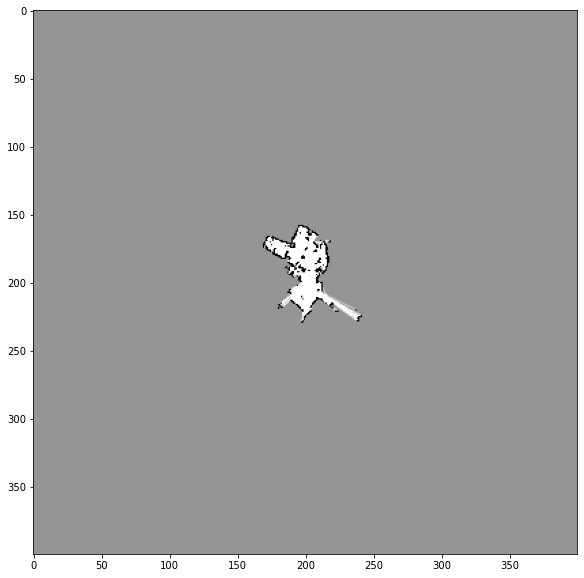

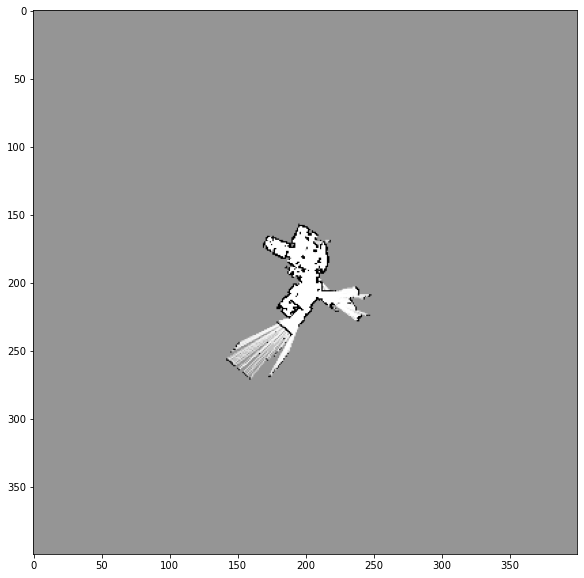

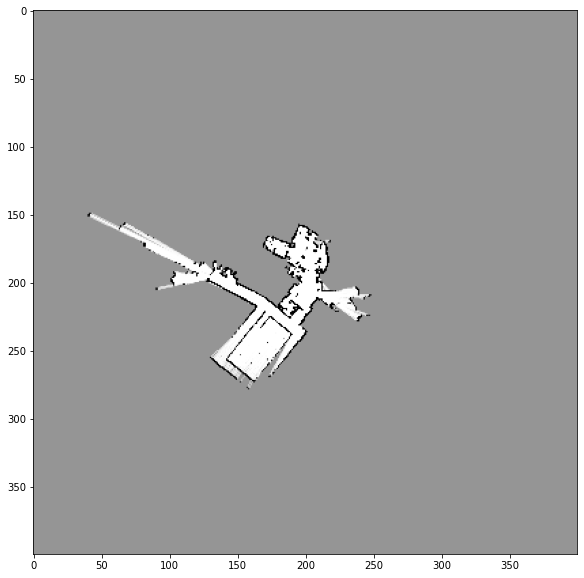

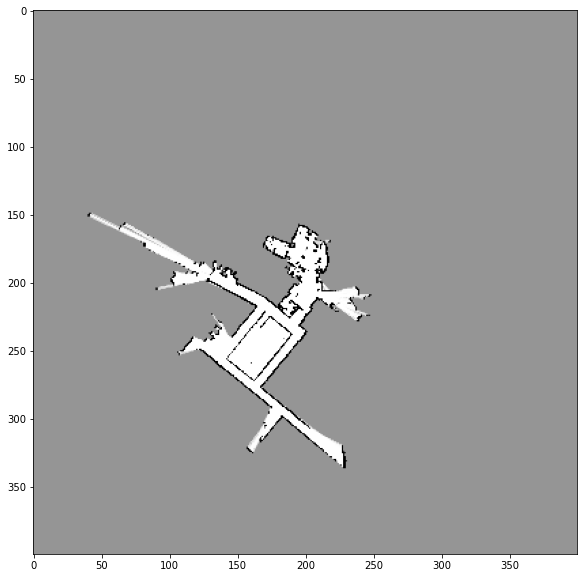

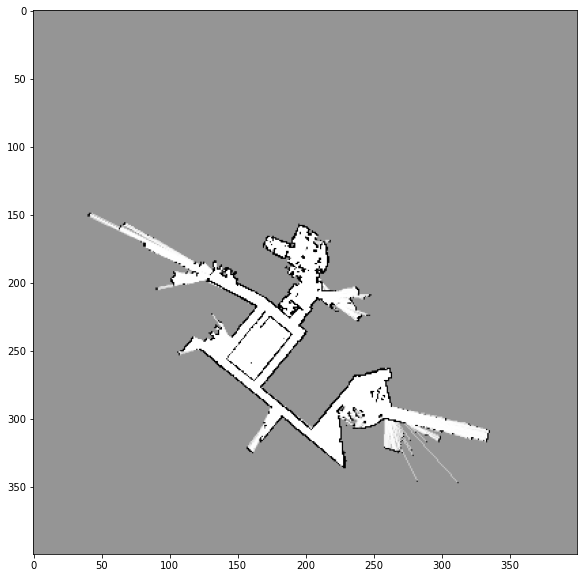

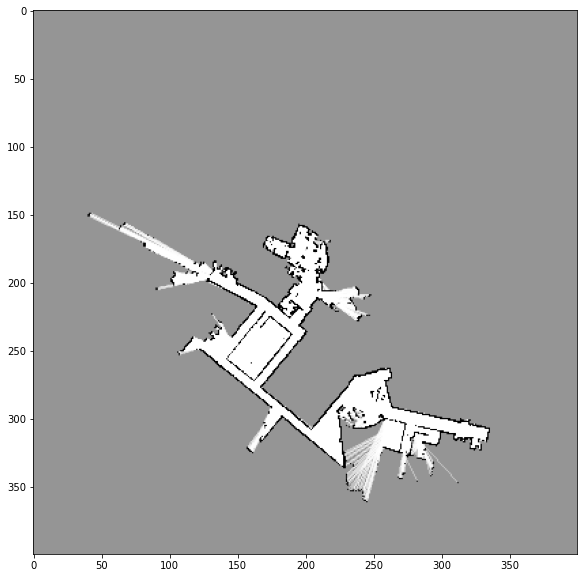

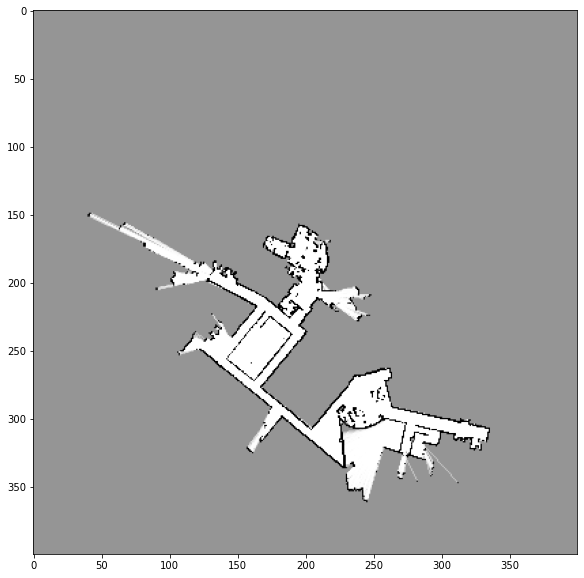

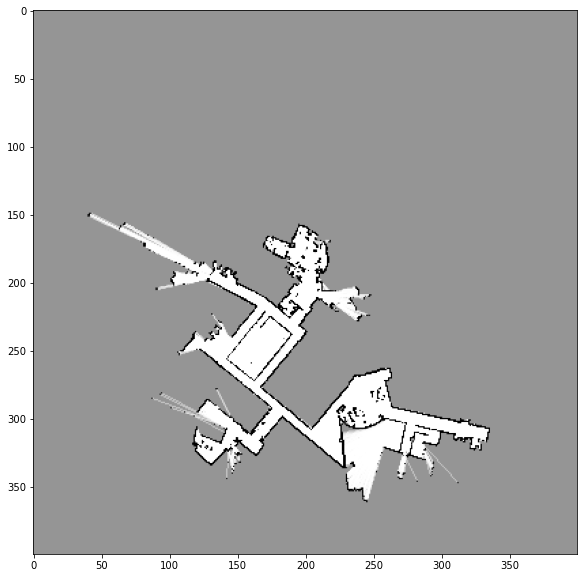

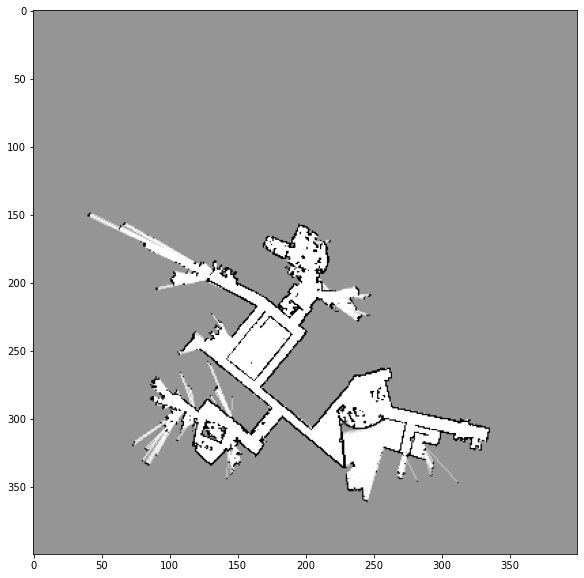

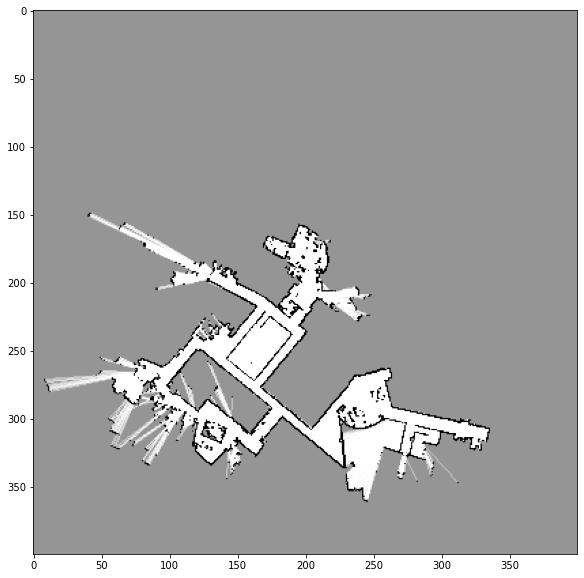

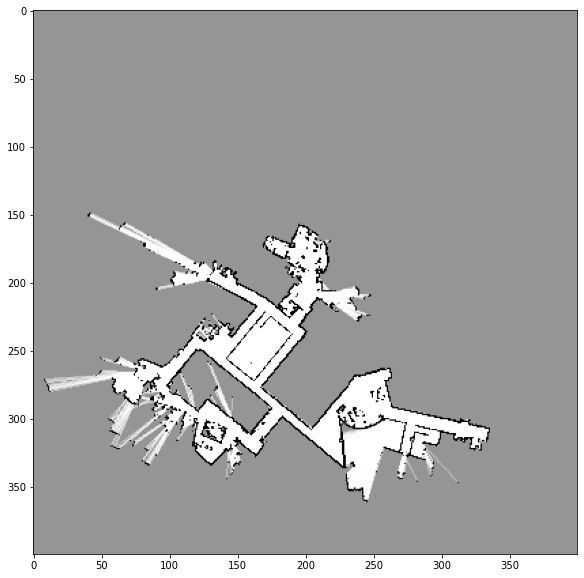

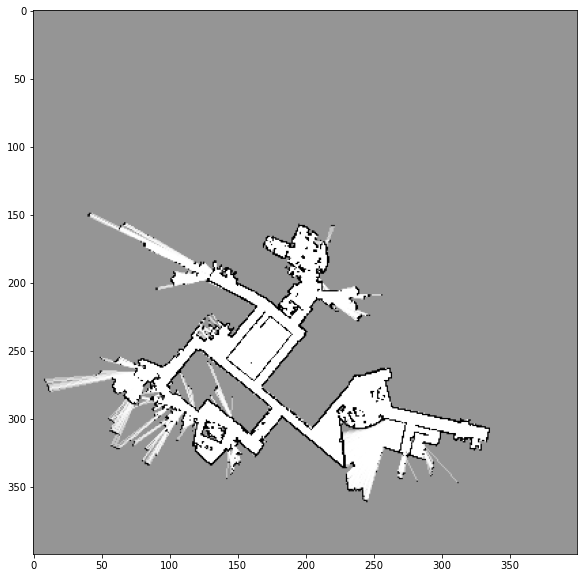

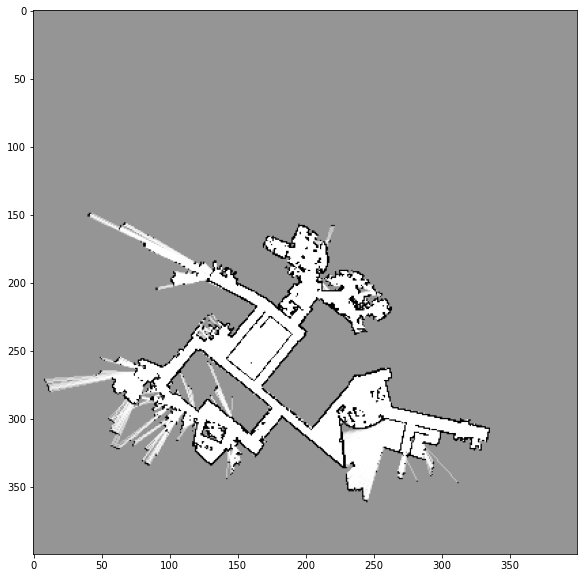

In [147]:
# All step
count_ = 0
for i in range(ranges_raw.shape[0]):
    occ_gridmap = grid_mapping_with_known_poses(ranges_raw[i,:], poses_raw[i,:], occ_gridmap, map_res, prob_occ, prob_free, prior)
    count_ = count_ + 1
    if count_ == 50:
        plot_gridmap(occ_gridmap)
        count_ = 0